## MJ07_김용현_4주차_미션1
## pytorch tutorial


### MNIST 데이터 준비
- MNIST data: 0에서 9 사이의 숫자 손글씨 데이터셋
- pathlib, requests 라이브러리를 사용한 데이터셋 다운로드

- 나의 경우에는 .ipynb와 같은 경로에 생성하지 않고 다른 경로에 생성 후 진행할 예정
- 아래는 현재 구성된 디렉토리
    - 코드 위치: ML/Boostcourse/Let's AI 2024/pytorch_turorial.ipynb
	- 데이터 위치: ML/data/MNIST

In [1]:
!cd ../.. && tree

.
├── Boostcourse
│   └── Let's AI 2024
│       ├── activation_function.ipynb
│       ├── images
│       │   ├── LeakyRelu_output.png
│       │   ├── Relu_output.png
│       │   ├── sigmoid_output.png
│       │   ├── softmax_output.png
│       │   └── tanh_output.png
│       └── pytorch_tutorial.ipynb
├── CV
│   └── mnist_cnn.py
└── data
    └── MNIST
        ├── mnist.pkl.gz
        └── raw
            ├── t10k-images-idx3-ubyte
            ├── t10k-images-idx3-ubyte.gz
            ├── t10k-labels-idx1-ubyte
            ├── t10k-labels-idx1-ubyte.gz
            ├── train-images-idx3-ubyte
            ├── train-images-idx3-ubyte.gz
            ├── train-labels-idx1-ubyte
            └── train-labels-idx1-ubyte.gz

8 directories, 17 files


In [2]:
from pathlib import Path
import requests
import os

PATH = Path.joinpath(Path.cwd().parent.parent, "data", "MNIST")

# mkdir: 디렉토리 생성 함수 == os.mkdir
# parents -> bool: 상위 디렉토리가 없으면 생성
# exist_ok -> bool: 이미 존재하는 경우에 에러 발생시키지 않음)
PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/main/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

# 데이터 다운로드 확인(bool)
os.path.isfile(PATH.joinpath(FILENAME))


True

In [3]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

data type: <class 'numpy.ndarray'>
data shape: (50000, 784)


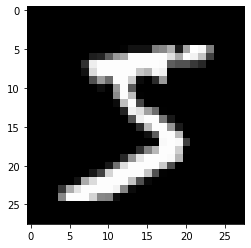

In [4]:
import matplotlib.pyplot as plt 
import numpy as np

plt.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(f"data type: {type(x_train)}")
print(f"data shape: {x_train.shape}")


In [5]:
# ndarray2tensor
import torch

x_train, y_train, x_valid, y_valid = map(
	torch.tensor, (x_train, y_train, x_valid, y_valid)
)

print(x_train, y_train)
print(x_train.shape)
print(type(x_train))
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
<class 'torch.Tensor'>
tensor(0) tensor(9)


### 간단한 선형 모델의 가중치, 절편 생성
- 기울기가 요구됨을 명시(requires_grad)
- 가중치 초기화
    - [Xavier initialisation](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf)
    - 1 / np.sqrt(n)

In [6]:
n, c = x_train.shape # (50000, 784)
weights = torch.randn(c, 10) / np.sqrt(c)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)
weights, bias

(tensor([[ 0.0381,  0.0303,  0.0254,  ..., -0.0298, -0.0105, -0.0200],
         [ 0.0075, -0.0069,  0.0161,  ..., -0.0631, -0.1053, -0.0178],
         [ 0.0250,  0.0393, -0.0686,  ..., -0.0694, -0.0202, -0.0474],
         ...,
         [ 0.0739,  0.0340, -0.0147,  ...,  0.0876, -0.0635, -0.0467],
         [-0.0162, -0.0548, -0.0323,  ..., -0.0248, -0.0303, -0.0297],
         [ 0.0079,  0.0545,  0.0015,  ..., -0.0098, -0.0687,  0.0026]],
        requires_grad=True),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True))

In [7]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb @ weights + bias) # @: 행렬곱(mat mul)

In [8]:
bs = 64 # batch size

xb = x_train[0:bs] # x로부터 mini batch 호출
preds = model(xb)
preds[0], preds.shape

(tensor([-2.6204, -2.7039, -2.5492, -2.6541, -2.2749, -3.0749, -1.6442, -1.8179,
         -2.0820, -2.4942], grad_fn=<SelectBackward0>),
 torch.Size([64, 10]))

In [9]:
def nll(input, target):
	'''negative log-likelihood func'''
	return -(input[range(target.shape[0]), target].mean())

loss_func = nll

In [10]:
yb = y_train[0:bs]
print(loss_func(preds, yb))

tensor(2.3780, grad_fn=<NegBackward0>)


In [11]:
def accuracy(out, yb):
    '''calculate acc'''
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

print(accuracy(preds, yb))

tensor(0.1719)


In [12]:
from IPython.core.debugger import set_trace

lr = 0.5  # 학습률(learning rate)
epochs = 2  # 훈련에 사용할 에폭(epoch) 수

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        #set_trace()
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

In [13]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0830, grad_fn=<NegBackward0>) tensor(1.)


### refactoring
- use nn classe in pytorch

In [14]:
import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
    return xb @ weights + bias

In [15]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0830, grad_fn=<NllLossBackward0>) tensor(1.)


- Use nn.Module

In [16]:
from torch import nn 

class Mnist_logistic(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.weights = nn.Parameter(torch.rand(784, 10) / np.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))
        
    def forward(self, xb):
        return xb @ self.weights + self.bias


In [17]:
model = Mnist_logistic()
loss_func(model(xb), yb)

tensor(2.2900, grad_fn=<NllLossBackward0>)

In [18]:
def fit():
    for epoch in range(epochs):
        for i in range((n - 1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()

fit()

In [19]:
loss_func(model(xb), yb)

tensor(0.0809, grad_fn=<NllLossBackward0>)

### Use nn.Linear

In [20]:
class Mnist_logistic(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.lin = nn.Linear(784, 10)
    
    def forward(self, xb):
     return self.lin(xb)
 
model = Mnist_logistic()
loss_func(model(xb), yb)

tensor(2.4269, grad_fn=<NllLossBackward0>)

In [21]:
fit()
loss_func(model(xb), yb)

tensor(0.0809, grad_fn=<NllLossBackward0>)

### Use torch.optim

In [22]:
from torch import optim

def get_model():
    model = Mnist_logistic()
    return model, optim.SGD(model.parameters(), lr=lr)

model, opt = get_model()
print(loss_func(model(xb), yb))

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(2.2509, grad_fn=<NllLossBackward0>)
tensor(0.0819, grad_fn=<NllLossBackward0>)


### Use Dataset

In [23]:
from torch.utils.data import TensorDataset

train_ds = TensorDataset(x_train, y_train)

model, opt = get_model()

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        xb, yb = train_ds[i * bs: i * bs + bs]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0801, grad_fn=<NllLossBackward0>)


# Use DataLoader
- 미니배치를 자동적으로 제공

In [24]:
from torch.utils.data import DataLoader

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=64)

In [25]:
model, opt = get_model()

for epoch in range(epochs):
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0811, grad_fn=<NllLossBackward0>)


### Add validation
- 과적합 방지
- shuffling: 배치와 과적합 사이의 상관관계 방지

In [26]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

In [27]:
model, opt = get_model()

for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

    model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl)

    print(epoch, valid_loss / len(valid_dl))

0 tensor(0.3207)
1 tensor(0.2780)


### fit(), get_data() 생성
- 훈련 데이터셋과 검증 데이터셋 모두 손실을 계산하는 유사한 프로세스를 거침
- 이를 하나의 배치에 대한 손실을 계산하는 자체 함수 ```loss_batch```로 만들기

In [28]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

In [29]:
import numpy as np

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)

In [30]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

In [31]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.3495790726184845
1 0.3126186164498329


### CNN
- 3개의 conv layer로 신경망 구축
- 사전정의된 conv2d 사용
- 각 conv 뒤에는 ReLU가 있음
- 마지막으로 average pooling 수행

In [32]:
class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)

    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28)
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb, 4)
        return xb.view(-1, xb.size(1))

In [33]:
lr = 0.1
model = Mnist_CNN()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.37335104851722717
1 0.2763823552250862


### Use nn.sequential
- ```Sequential``` 객체는 그 안에 포함된 각 모듈을 순차적으로 실행
- custom layer를 쉽게 정의할 수 있어야 활용 가능

In [34]:
class Lambda(nn.Module):
    def __init__(self, func) -> None:
        super().__init__()
        self.func = func
        
    def forward(self, x):
        return self.func(x)
    
def preprocess(x):
    return x.view(-1, 1, 28, 28)

In [35]:
model = nn.Sequential(
    Lambda(preprocess),
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.37059186985492704
1 0.29486834902763365


### DataLoader 감싸기
- 우리의 CNN은 간결하지만 MNIST에서만 작동한다
1. 입력이 28*28의 긴 벡터라고 가정
2. 최종적으로 CNN 그리그의 크기는 4*4 라고 가정(avg pooling 커널 사이즈)

In [36]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28), y


class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

In [37]:
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [38]:
fit(epochs=epochs, model=model, loss_func=loss_func, opt=opt, train_dl=train_dl, valid_dl=valid_dl)

0 0.3329599163413048
1 0.24579082554578782


### GPU 사용하기
- cuda, mps, cpu

In [39]:
print(torch.cuda.is_available()) # m1 mac이기 떄문에 False가 나와야함

False


In [40]:
use_cuda = torch.cuda.is_available()
use_mps = torch.backends.mps.is_available() # MPS: Apple’s Metal Performance Shaders

if use_cuda:
        device = torch.device("cuda")
elif use_mps:
	device = torch.device("mps")
else:
	device = torch.device("cpu")
 
device

device(type='mps')

In [41]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28).to(device), y.to(device)

train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

In [42]:
model.to(device)
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [43]:
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.19353530004322528
1 0.1923387282371521


In [54]:
# save model
save_pt_path = Path.joinpath(Path.cwd(), "model")
save_pt_path.mkdir(parents=True, exist_ok=True)
torch.save(model.state_dict(), Path.joinpath(save_pt_path, "mnist_tutorial.pt"))
os.path.isfile(os.path.join(save_pt_path, "mnist_tutorial.pt"))

True